# Temat
---
Celem projektu jest opracowanie modelu predykcyjnego, który najdokładniej przewidzi dzienną liczbę kroków
użytkownika. Kluczowym zagadnieniem jest identyfikacja optymalnego podejścia opartego na szeregach
czasowych, które efektywnie wykorzysta dane historyczne z czujników w połączeniu z informacjami
dodatkowymi, takimi jak warunki pogodowe i kontekst kalendarzowy.


In [1]:
import warnings
import logging

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

In [2]:
import xml.etree.ElementTree as ET
import requests
import pandas as pd
import plotly.express as px
import numpy as np
import missingno as msno
import lib.functions as functions
import matplotlib.pyplot as plt
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import time

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import optuna

pio.templates.default = "plotly_dark"
api_key = ''

# Zebranie danych
___
Dane zostały pobrane z aplikacji *Health* i pochodzą z czujników telefonu komórkowego, które rejestrowały informacje w okresie od 9 grudnia 2017 do 31 grudnia 2024. Dodatkowo, zestaw danych został wzbogacony o historyczne dane pogodowe zebrane za pomocą API *weather.visualcrossing.com*, dostosowane do lokalizacji Warszawy.

Zawartość danych obejmuje datę pomiaru, liczbę kroków w danym okresie czasowym, warunki pogodowe oraz informacje kalendarzowe.

In [3]:
file_path = 'data/apple_health_export_data/export.xml'    
tree = ET.parse(file_path)
root = tree.getroot()

records = []
for record in root.findall('Record'):
    entry = {
        "sourceName": record.attrib.get("sourceName"),
        "type": record.attrib.get("type"),
        "creationDate": record.attrib.get("creationDate"),
        "startDate": record.attrib.get("startDate"),
        "endDate": record.attrib.get("endDate"),
        "value": record.attrib.get("value"),
        "unit": record.attrib.get("unit"),
    }
    records.append(entry)

health_data = pd.DataFrame(records)
health_data.to_csv('data/health_data.csv', index=False)

In [4]:
health_data.head(5)

sourceName                               type  \
0                 iPhone     HKQuantityTypeIdentifierHeight   
1                 iPhone   HKQuantityTypeIdentifierBodyMass   
2                 Health   HKQuantityTypeIdentifierBodyMass   
3  Apple Watch (Zuzanna)  HKQuantityTypeIdentifierHeartRate   
4  Apple Watch (Zuzanna)  HKQuantityTypeIdentifierHeartRate   

                creationDate                  startDate  \
0  2020-02-01 13:16:57 +0100  2020-02-01 13:16:57 +0100   
1  2020-02-01 13:16:57 +0100  2020-02-01 13:16:57 +0100   
2  2024-06-08 09:13:17 +0100  2024-06-08 09:13:00 +0100   
3  2020-02-01 13:20:25 +0100  2020-02-01 13:17:59 +0100   
4  2020-02-01 13:29:35 +0100  2020-02-01 13:29:21 +0100   

                     endDate value       unit  
0  2020-02-01 13:16:57 +0100   168         cm  
1  2020-02-01 13:16:57 +0100    55         kg  
2  2024-06-08 09:13:00 +0100    50         kg  
3  2020-02-01 13:17:59 +0100    69  count/min  
4  2020-02-01 13:29:21 +0100    68  count/min

In [5]:
health_data.groupby('type').size().sort_values(ascending=False)

type
HKQuantityTypeIdentifierActiveEnergyBurned                82235
HKQuantityTypeIdentifierDistanceWalkingRunning            65537
HKQuantityTypeIdentifierStepCount                         55403
HKQuantityTypeIdentifierBasalEnergyBurned                 42949
HKQuantityTypeIdentifierHeartRate                         31951
HKQuantityTypeIdentifierHeadphoneAudioExposure            29356
HKQuantityTypeIdentifierWalkingStepLength                  8889
HKQuantityTypeIdentifierWalkingSpeed                       8889
HKQuantityTypeIdentifierFlightsClimbed                     8494
HKQuantityTypeIdentifierWalkingDoubleSupportPercentage     8014
HKQuantityTypeIdentifierAppleStandTime                     6290
HKQuantityTypeIdentifierAppleExerciseTime                  5873
HKQuantityTypeIdentifierWalkingAsymmetryPercentage         4826
HKQuantityTypeIdentifierBodyTemperature                    3868
HKCategoryTypeIdentifierSleepAnalysis                      3754
HKCategoryTypeIdentifierAppleStandH

##
---

In [6]:
url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Warsaw,PL/2017-12-09/2024-12-31?unitGroup=metric&key={api_key}&include=days'

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    weather_data = pd.DataFrame(data['days'])
    weather_data.to_csv('data/weather_data.csv', index=False)
else:
    print(f"Error: {response.status_code}, {response.text}")

Error: 401, No API key or session found. Please verify that your API key parameter is correct.


In [7]:
weather_data.head(5)

NameError: name 'weather_data' is not defined

In [79]:
weather_data.columns

Index(['datetime', 'datetimeEpoch', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'pressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'sunrise', 'sunriseEpoch', 'sunset', 'sunsetEpoch', 'moonphase',
       'conditions', 'description', 'icon', 'stations', 'source', 'tzoffset'],
      dtype='object')

# Przygotowanie danych

### Dane dotyczące aktywności
---

In [4]:
health_data = pd.read_csv('data/health_data.csv', low_memory=False)

In [5]:
steps = health_data[(health_data['sourceName'].isin(['iPhone', 'iPhone (Zuzanna)'])) & (health_data['type'] == 'HKQuantityTypeIdentifierStepCount')][['creationDate', 'value']].reset_index(drop=True)
steps['creationDate'] = pd.to_datetime(steps['creationDate']).dt.normalize().dt.tz_localize(None)
steps['value'] = steps['value'].astype(int)  
steps = steps.rename(columns={'creationDate': 'date'})
steps = steps.groupby('date').sum().reset_index()
date_range = pd.date_range(start="2017-12-09", end="2024-12-31", freq='D')
dates_df = pd.DataFrame(date_range, columns=['date'])
steps = pd.merge(dates_df, steps, on='date', how='left')
steps.head()

date   value
0 2017-12-09   617.0
1 2017-12-10  1325.0
2 2017-12-11  2559.0
3 2017-12-12  7467.0
4 2017-12-13  4866.0

In [6]:
functions.check_df(df=steps)

##################### SHAPE #####################
(2580, 2)
##################### TYPES #####################
date     datetime64[ns]
value           float64
dtype: object
##################### HEAD #####################
        date   value
0 2017-12-09   617.0
1 2017-12-10  1325.0
2 2017-12-11  2559.0
3 2017-12-12  7467.0
4 2017-12-13  4866.0
##################### TAIL #####################
           date  value
2575 2024-12-27   73.0
2576 2024-12-28  230.0
2577 2024-12-29   41.0
2578 2024-12-30  169.0
2579 2024-12-31  749.0
##################### N/A #####################
date      0
value    54
dtype: int64


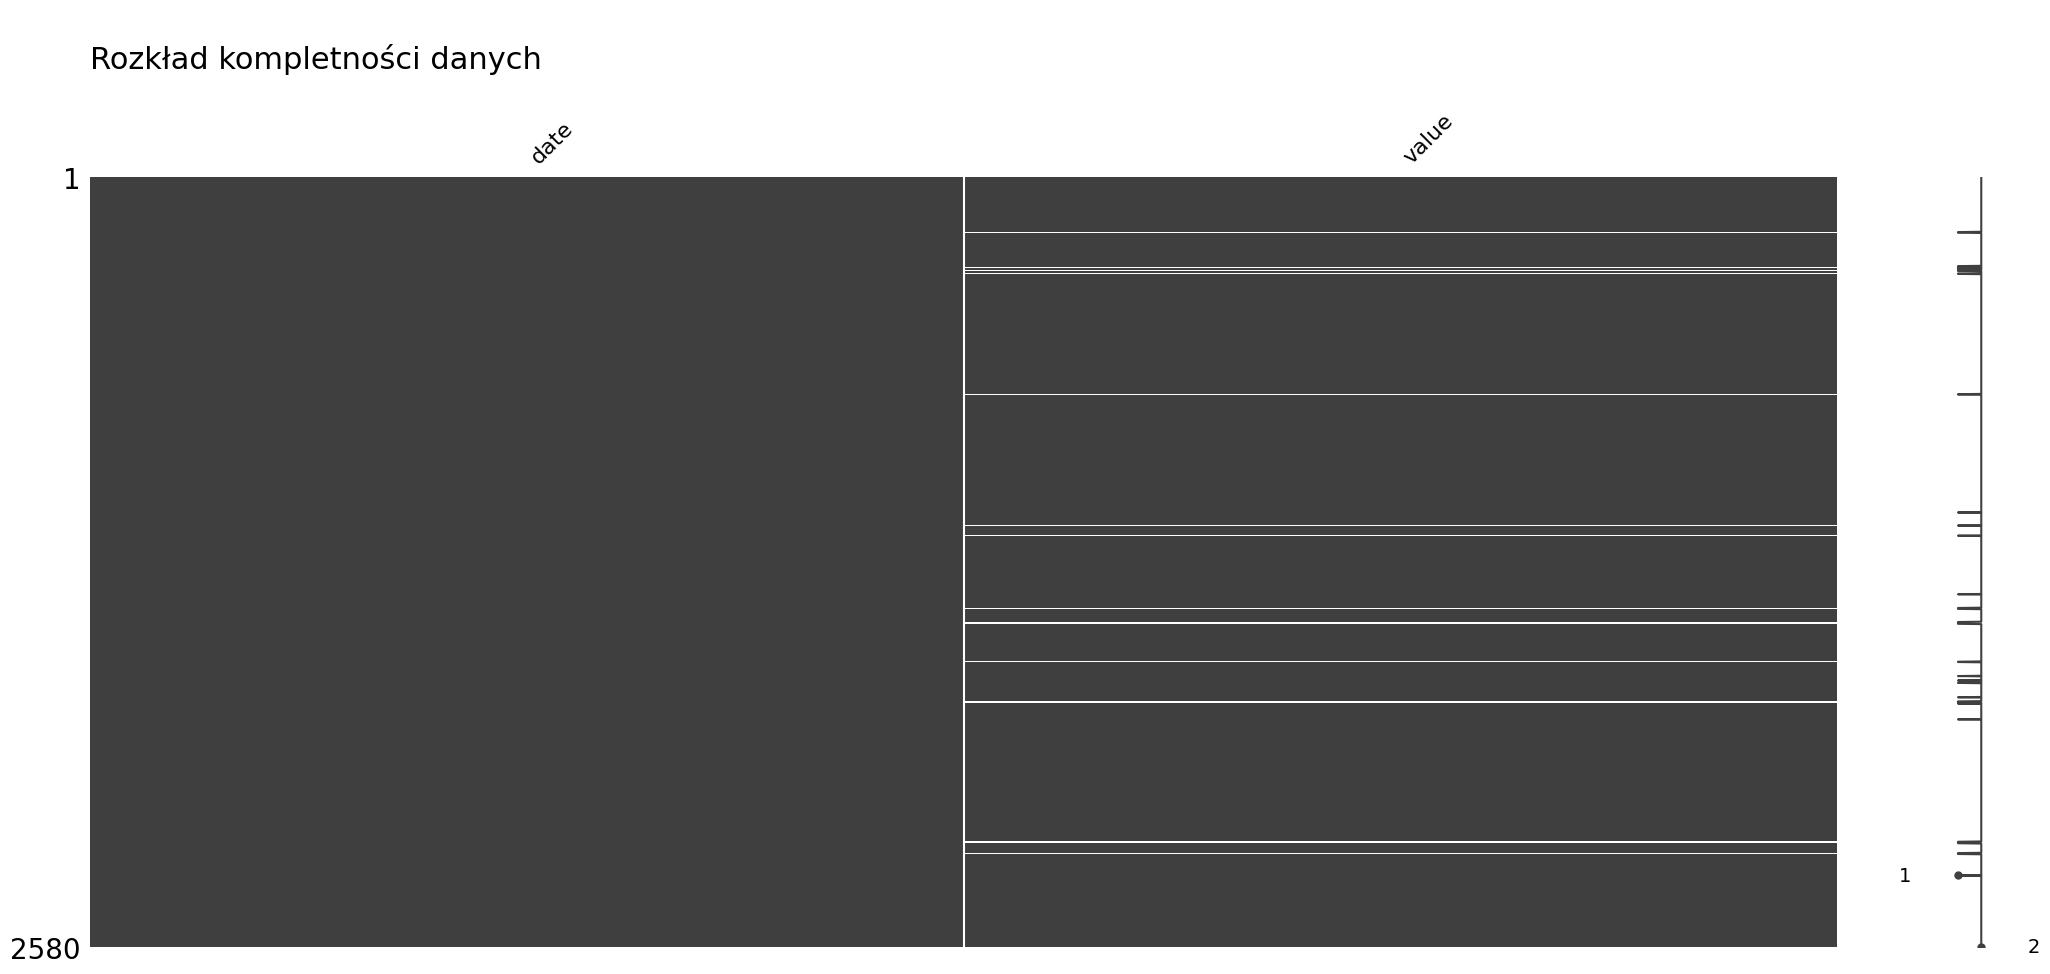

Daty, w których występują brakujące wartości:
184    2018-06-11
185    2018-06-12
186    2018-06-13
298    2018-10-03
302    2018-10-07
303    2018-10-08
307    2018-10-12
311    2018-10-16
312    2018-10-17
313    2018-10-18
314    2018-10-19
323    2018-10-28
324    2018-10-29
727    2019-12-06
728    2019-12-07
1123   2021-01-05
1167   2021-02-18
1201   2021-03-24
1397   2021-10-06
1443   2021-11-21
1444   2021-11-22
1445   2021-11-23
1446   2021-11-24
1490   2022-01-07
1491   2022-01-08
1492   2022-01-09
1493   2022-01-10
1494   2022-01-11
1495   2022-01-12
1496   2022-01-13
1623   2022-05-20
1624   2022-05-21
1671   2022-07-07
1686   2022-07-22
1694   2022-07-30
1742   2022-09-16
1756   2022-09-30
1757   2022-10-01
1758   2022-10-02
1759   2022-10-03
1760   2022-10-04
1763   2022-10-07
1816   2022-11-29
2226   2024-01-13
2227   2024-01-14
2228   2024-01-15
2229   2024-01-16
2230   2024-01-17
2231   2024-01-18
2264   2024-02-20
2265   2024-02-21
2266   2024-02-22
2267   2024-02-23


In [7]:
msno.matrix(steps)
plt.title('\nRozkład kompletności danych\n', fontsize=22, loc='left')
plt.show()

print("Daty, w których występują brakujące wartości:")
missing_dates = steps[steps['value'].isna()]['date']
print(missing_dates)

Brakujące dane dotyczące liczby kroków pojawiają się w przypadkowych miejscach, bez wyraźnego wzorca..

In [8]:
functions.plot_column_distribution(steps, 'value', 'Rozkład liczby kroków')

Statystyki dla kolumny 'value':
count     2526.000000
mean      3550.988915
std       4313.730680
min          1.000000
25%        413.000000
50%       1840.500000
75%       5358.250000
max      43670.000000
Name: value, dtype: float64


Większość wartości jest stosunkowo niska, a rozkład danych jest silnie asymetryczny. Występują sporadyczne, bardzo wysokie wartości odstające. Średnia jest zawyżona przez skrajne przypadki, co wskazuje na dużą zmienność w danych.

In [8]:
functions.outliers_summary(steps, 'value')

Łączna liczba wartości odstających: 100

Statystyki dla wartości odstających:
count      100.000000
mean     17212.520000
std       5007.313109
min      12787.000000
25%      13734.250000
50%      15824.000000
75%      18562.250000
max      43670.000000
Name: value, dtype: float64


Wartości odstające stanowią niewielką część danych, ale ich średnia znacznie przekracza ogólną średnią, co wskazuje na sporadyczne dni o wyjątkowo wysokiej aktywności.

In [9]:
steps = functions.replace_outliers_and_nans(steps, 'value')
functions.plot_column_distribution(steps, 'value', 'Rozkład liczby kroków po interpolacji')

Statystyki dla kolumny 'value':
count     2580.000000
mean      3059.534496
std       3205.394559
min          1.000000
25%        409.000000
50%       1795.500000
75%       4937.750000
max      12748.000000
Name: value, dtype: float64


Po interpolacji dane są bardziej spójne, a ich rozkład zachowuje ogólną strukturę. Zmniejszono wpływ wartości odstających i nieciągłości, poprawiając ciągłość danych bez znaczących zmian w kształcie rozkładu.

### Dane pogodowe
---

Z początkowego zbioru danych pogodowych dokonano selekcji parametrów, które najbardziej prawdopodobnie wpływają na aktywność fizyczną. Wybrane zmienne to temperatura powietrza (temp), wilgotność (humidity), opady deszczu (precipcover), prędkość wiatru (windspeed), stopień zachmurzenia (cloudcover), widoczność (visibility) oraz promieniowanie słoneczne (solarradiation). 

In [10]:
weather_data = pd.read_csv('data/weather_data.csv')

In [11]:
weather = weather_data[['datetime', 'temp',  'humidity', 'precipcover', 'windspeed', 'cloudcover','visibility',  'solarradiation']].rename(columns={'datetime': 'date'})
weather.date = pd.to_datetime(weather.date)
weather

date  temp  humidity  precipcover  windspeed  cloudcover  \
0    2017-12-09   0.7      81.8         0.00       14.5        71.9   
1    2017-12-10   0.9      78.0         0.00       20.3        77.7   
2    2017-12-11   3.5      77.2         8.33       21.1        81.6   
3    2017-12-12   7.3      69.6         0.00       26.5        78.7   
4    2017-12-13   1.5      73.0         0.00       20.4        59.3   
...         ...   ...       ...          ...        ...         ...   
2575 2024-12-27   1.1      97.8         0.00        8.4        99.1   
2576 2024-12-28   0.8      97.9         0.00        7.4       100.0   
2577 2024-12-29   2.2      96.4         0.00       18.5        86.4   
2578 2024-12-30   0.9      96.8         0.00       23.4       100.0   
2579 2024-12-31   1.1      92.0         0.00       27.4        76.3   

      visibility  solarradiation  
0           12.3            28.6  
1           14.1            25.4  
2           17.0            16.9  
3           17.7            21.1  
4           15.4            24.4  
...          ...             ...  
2575         3.1            11.8  
2576         4.2             5.7  
2577         3.8            16.0  
2578         5.5             3.2  
2579         8.5             8.7  

[2580 rows x 8 columns]

In [12]:
functions.check_df(weather)

##################### SHAPE #####################
(2580, 8)
##################### TYPES #####################
date              datetime64[ns]
temp                     float64
humidity                 float64
precipcover              float64
windspeed                float64
cloudcover               float64
visibility               float64
solarradiation           float64
dtype: object
##################### HEAD #####################
        date  temp  humidity  precipcover  windspeed  cloudcover  visibility  \
0 2017-12-09   0.7      81.8         0.00       14.5        71.9        12.3   
1 2017-12-10   0.9      78.0         0.00       20.3        77.7        14.1   
2 2017-12-11   3.5      77.2         8.33       21.1        81.6        17.0   
3 2017-12-12   7.3      69.6         0.00       26.5        78.7        17.7   
4 2017-12-13   1.5      73.0         0.00       20.4        59.3        15.4   

   solarradiation  
0            28.6  
1            25.4  
2            16.9  
3 

In [13]:
functions.plot_boxplot_summary(weather, 'Rozkłady poszczególnych zmiennych pogodowych')

Statystyki dla zmiennych numerycznych:
          humidity  precipcover    windspeed   cloudcover   visibility  \
count  2580.000000  2580.000000  2580.000000  2580.000000  2580.000000   
mean     73.348256     5.717504    19.880078    61.192674    14.324767   
std      14.553708    11.276712     6.731558    23.365275     4.164520   
min      29.000000     0.000000     4.600000     0.000000     1.200000   
25%      63.300000     0.000000    15.100000    46.000000    11.700000   
50%      74.900000     0.000000    19.000000    63.750000    15.600000   
75%      85.125000     4.170000    23.900000    79.800000    17.800000   
max      99.500000    91.670000    52.000000   100.000000    21.900000   

       solarradiation  
count     2580.000000  
mean       117.476822  
std         89.531992  
min          3.200000  
25%         31.775000  
50%         98.800000  
75%        191.325000  
max        342.900000  


Większość zmiennych cechuje niewielkie rozproszenie, jednak promieniowanie słoneczne i opady deszczu wykazują silną asymetrię oraz liczne wartości odstające. Skrajne przypadki zawyżają średnią, co świadczy o dużej zmienności tych zmiennych.

# Analiza danych

In [3]:
steps = functions.create_date_features(steps, 'date')
df = pd.merge(steps, weather, how='left', on='date')
df.head()

NameError: name 'steps' is not defined

## Analiza szeregu czasowego
---

In [15]:
fig = px.line(df, y='value', x='date', title="Wizualizacja liczby kroków w latach 2018-2024", labels={'value': 'Ilość kroków'})
fig.update_xaxes(title_text='Data', tickformat='%Y-%m') 
fig.show()

Widać dużą zmienność oraz liczne skoki wartości w różnych okresach. Szczególnie widoczny jest spadek aktywności w okolicach 2020 roku. Po 2021 roku pojawia się większa nieregularność, choć wartości wciąż wykazują znaczną zmienność w określonych momentach.

In [16]:
result = adfuller(df.value)
print(f"Test ADF statystyka = {result[0]:.4f}, p-value = {result[1]:.4f}")
print("Wynik testu ADF sugeruje, że szereg czasowy jest stacjonarny." if result[1] < 0.05 else "Wynik testu ADF sugeruje, że szereg czasowy nie jest stacjonarny.")

Test ADF statystyka = -5.2570, p-value = 0.0000
Wynik testu ADF sugeruje, że szereg czasowy jest stacjonarny.


In [17]:
functions.plot_seasonal_decompose(df, 'value', title='Dekompozycja')

Ogólny trend spadkowy do 2020 roku, a następnie stopniowy wzrost aktywności. Sezonowość pozostaje stabilna przez cały okres, wskazując na cykliczne wzorce w danych. Reszty wykazują losowe wahania bez wyraźnych anomalii.

In [18]:
functions.plot_autocorrelation(df.value, title='Autokorelacja (ACF)', alpha=0.01, show_pacf=False)
functions.plot_autocorrelation(df.value, title='Cząstkowa autokorelacja (PACF)', alpha=0.01, show_pacf=True)

Silna korelacja dla lagów 1-2 oznacza, że aktywność jednego dnia mocno zależy od poprzedniego. Natomiast podwyższone wartości dla 7, 14 i 21 wskazują na powtarzający się tygodniowy schemat aktywności.

In [458]:
window_sizes = np.arange(1, 51)
diff_values = []

for window in window_sizes:
    diff_series = df['value'].diff(periods=window).dropna()
    avg_diff = np.mean(np.abs(diff_series))
    diff_values.append(avg_diff)

df_diff = pd.DataFrame({
    'Window Size': window_sizes,
    'Average Diff': diff_values
})

functions.plot_line(df_diff, 'Window Size', 'Average Diff', 'Wpływ długości okna na różnicę z oryginalnym szeregiem', labels={'Window Size': 'Długość okna', 'Average Diff': 'Średnia różnica diff'})

Silne różnice dla krótkich okien sugerują, że krótkoterminowe zmiany mają duży wpływ na szereg czasowy. Podwyższone wartości dla okien 7, 14 i 21 dni wskazują na tygodniowe i wielotygodniowe cykle sezonowości. Natomiast wyższe wartości dla około 30-40 dni mogą wskazywać na miesięczne wzorce aktywności.

In [460]:
correlations = functions.calculate_rolling_means_and_correlation_with_value(df, max_window=60)
fig = px.bar(correlations, x=correlations.index, y=correlations.values, labels={'index': 'Liczba uśrednionych dni', 'y': 'Korelacja z aktywnością'}, title='Korelacja średnich kroczących z aktywnością w zależności od liczby dni uśredniania')
fig.show()

Korelacja jest najwyższa dla krótkich średnich kroczących i stopniowo maleje wraz ze wzrostem okna średniej kroczącej, wskaując na dominację trendu krótkoterminowego nad długoterminowym.

## Analiza zmiannych dodatkowych
---

In [19]:
functions.plot_correlation_clustermap(df, 'Mapa korelacji')

Korelacje między liczbą kroków a innymi zmiennymi są ogólnie słabe, z najwyższymi wartościami dla roku, pokrywy opadów i zachmurzenia. Zmienne pogodowe oraz czasowe nie wykazują istotnych powiązań, a ich wpływ na aktywność jest znikomy.

In [20]:
functions.plot_nonlinear_relationship(df, target='value', title='Mapa zależności nieliniowych')

Analiza nieliniowych zależności nie ujawnia silniejszych powiązań niż korelacje liniowe. Mutual information wskazuje na niewielkie zależności dla roku, miesiąca i dnia tygodnia, podczas gdy większość zmiennych pogodowych pozostaje bez istotnego wpływu.

### Zmienne kalendarzowe
---

In [21]:
functions.plot_boxplot(df, x='year', y='value', title='Aktywność w zależności od roku', labels={'value': 'Ilość kroków', 'year': 'Rok'})

In [22]:
steps_by_month = df.groupby('month')['value'].mean().reset_index()
functions.plot_line(steps_by_month, 'month', 'value', 'Średnia aktywność w miesiącu', labels={'value': 'Ilość kroków', 'month': 'Miesiąc'})

In [23]:
df_copy = df.copy()
df_copy['season'] = df_copy['month'].apply(lambda x: 'warm' if 4 <= x <= 9 else 'cold')
functions.plot_boxplot(df_copy, x='season', y='value', title='Aktywność w zależności od sezonu', labels={'value': 'Ilość kroków', 'season': 'Sezon'})
functions.group_normality_and_comparison(df_copy, target='value', group_col='season', alternative='greater')

Test Shapiro-Wilka dla grupy cold: p = 0.0000
Test Shapiro-Wilka dla grupy warm: p = 0.0000
Test Manna-Whitneya: statystyka = 867864.0000, p-wartość = 0.0290
Różnice między grupami są statystycznie istotne.


Liczba kroków w chłodnych miesiącach jest statystycznie wyższa niż w ciepłych miesiącach.

In [24]:
steps_by_week = df.groupby('day_of_week')['value'].mean().reset_index()
functions.plot_line(steps_by_week, 'day_of_week', 'value', 'Średnia aktywność w poszczególnych dniach tygodnia', labels={'value': 'Ilość kroków', 'day_of_week': 'Dzień tygodnia'})

In [25]:
functions.plot_boxplot(df, x='is_wknd', y='value', title='Aktywność w zależności od dnia tygodnia', labels={'value': 'Ilość kroków',  'is_wknd': 'Typ dnia (0 - dni robocze, 1 - weekend)'})
functions.group_normality_and_comparison(df, target='value', group_col='is_wknd', alternative='less')

Test Shapiro-Wilka dla grupy 1: p = 0.0000
Test Shapiro-Wilka dla grupy 0: p = 0.0000
Test Manna-Whitneya: statystyka = 767041.5000, p-wartość = 0.0051
Różnice między grupami są statystycznie istotne.


Liczba kroków w weekend jest statystycznie niższa niż w dni robocze.

### Zmienne pogodowe
---

In [26]:
monthly_activity = df.groupby('month').agg({'temp': 'mean', 'humidity': 'mean', 'precipcover': 'median', 'windspeed': 'mean', 'cloudcover': 'median', 'visibility': 'mean', 'solarradiation': 'mean', 'value': 'median'}).reset_index()
scaler = StandardScaler()
columns_to_normalize = ['temp', 'humidity', 'precipcover', 'windspeed', 'cloudcover', 'visibility', 'solarradiation', 'value']
monthly_activity_normalized = monthly_activity.copy()
monthly_activity_normalized[columns_to_normalize] = scaler.fit_transform(monthly_activity[columns_to_normalize])
functions.plot_line_subplots(monthly_activity_normalized, time_col='month', value_col='value', variables=['temp', 'humidity', 'precipcover', 'windspeed', 'cloudcover', 'visibility', 'solarradiation'], title='Znormalizowane wartości zmiennych pogodowych i liczby kroków w poszczególnych miesiącach')

Zmienność liczby kroków w poszczególnych miesiącach wykazuje słabe korelacje z większością zmiennych pogodowych, z nieco wyraźniejszymi powiązaniami dla temperatury, pokrywy opadów i widoczności. Wpływ warunków atmosferycznych na aktywność jest niewielki i nie wskazuje na jednoznaczne zależności.

In [27]:
bins_temp = [-20, 0, 10, 20, 30] 
bin_labels_temp = ['<0°C', '0-10°C', '10-20°C', '>20°C']
functions.plot_scatter_binned(df, 'value', 'temp', bins=bins_temp, bin_labels=bin_labels_temp)

bins_humidity = [0, 30, 60, 90] 
bin_labels_humidity = ['0-30%', '30-60%', '60-90%']
functions.plot_scatter_binned(df, 'value','humidity', bins=bins_humidity, bin_labels=bin_labels_humidity)

bins_precipcover = [0, 25, 50, 75, 100] 
bin_labels_precipcover = ['0-25%', '25-50%', '50-75%', '75-100%']
functions.plot_scatter_binned(df, 'value','precipcover', bins=bins_precipcover, bin_labels=bin_labels_precipcover)

bins_windspeed = [0, 5, 15, 25, 35] 
bin_labels_windspeed = ['0-5 km/h', '5-15 km/h', '15-25 km/h', '25-35 km/h']
functions.plot_scatter_binned(df, 'value', 'windspeed', bins=bins_windspeed, bin_labels=bin_labels_windspeed)

bins_cloudcover = [0, 20, 40, 60, 80, 100] 
bin_labels_cloudcover = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
functions.plot_scatter_binned(df, 'value', 'cloudcover', bins=bins_cloudcover, bin_labels=bin_labels_cloudcover)

bins_visibility = [0, 5, 10, 20, 50]
bin_labels_visibility = ['0-5 km', '5-10 km', '10-20 km', '20-50 km']
functions.plot_scatter_binned(df, 'value', 'visibility', bins=bins_visibility, bin_labels=bin_labels_visibility)

bins_solarradiation = [0, 50, 100, 150, 200, 250] 
bin_labels_solarradiation = ['0-50 W/m²', '50-100 W/m²', '100-150 W/m²', '150-200 W/m²', '200-250 W/m²']
functions.plot_scatter_binned(df, 'value', 'solarradiation', bins=bins_solarradiation, bin_labels=bin_labels_solarradiation)

Zmienność liczby kroków w zależności od warunków pogodowych wykazuje umiarkowane powiązania, szczególnie dla temperatury, prędkości wiatru i promieniowania słonecznego, podczas gdy wilgotność i zachmurzenie nie wykazują wyraźnych trendów. Ekstremalne warunki, takie jak bardzo niska temperatura, silny wiatr czy ograniczona widoczność, mogą wpływać na redukcję aktywności, jednak ogólny wpływ pogody na liczbę kroków pozostaje ograniczony i niejednoznaczny.

In [28]:
df_copy = df.copy()
df_copy['humidity_level'] = df_copy['humidity'].apply(lambda x: 'high' if x > 90 else 'low')
functions.plot_boxplot(df_copy, x='humidity_level', y='value', title='Aktywność w zależności od humidity_level', labels={'value': 'Ilość kroków', 'humidity_level': 'humidity_level'})
functions.group_normality_and_comparison(df_copy, target='value', group_col='humidity_level', alternative='greater')

Test Shapiro-Wilka dla grupy low: p = 0.0000
Test Shapiro-Wilka dla grupy high: p = 0.0000
Test Manna-Whitneya: statystyka = 401396.0000, p-wartość = 0.0085
Różnice między grupami są statystycznie istotne.


Przy wilgotności >90% liczba kroków jest istotnie mniejsza.

In [29]:
df_copy = df.copy()
df_copy['precipitation_status'] = df_copy['precipcover'].apply(lambda x: 'rainy' if x > 0 else 'dry')
functions.plot_boxplot(df_copy, x='precipitation_status', y='value', title='Aktywność w zależności od precipitation_status', labels={'value': 'Ilość kroków', 'precipitation_status': 'precipitation_status'})
functions.group_normality_and_comparison(df_copy, target='value', group_col='precipitation_status', alternative='greater')

Test Shapiro-Wilka dla grupy dry: p = 0.0000
Test Shapiro-Wilka dla grupy rainy: p = 0.0000
Test Manna-Whitneya: statystyka = 876895.5000, p-wartość = 0.0045
Różnice między grupami są statystycznie istotne.


Liczba kroków jest mniejsza w deszczowe dni w porównaniu do słonecznych.

In [30]:
df_copy = df.copy()
df_copy['windspeed_category'] = df_copy['windspeed'].apply(lambda x: 'high' if x > 30 else 'low')
functions.plot_boxplot(df_copy, x='windspeed_category', y='value', title='Aktywność w zależności od windspeed_category', labels={'value': 'Ilość kroków', 'windspeed_category': 'windspeed_category'})
functions.group_normality_and_comparison(df_copy, target='value', group_col='windspeed_category', alternative='greater')

Test Shapiro-Wilka dla grupy low: p = 0.0000
Test Shapiro-Wilka dla grupy high: p = 0.0000
Test Manna-Whitneya: statystyka = 261956.0000, p-wartość = 0.0090
Różnice między grupami są statystycznie istotne.


W bardzo wietrzne dni liczba kroków jest istotnie mniejsza.

In [31]:
df_copy = df.copy()
df_copy['cloudcover_category'] = df_copy['cloudcover'].apply(lambda x: 'cloudy' if x >= 60 else 'clear')
functions.plot_boxplot(df_copy, x='cloudcover_category', y='value', title='Aktywność w zależności od cloudcover_category', labels={'value': 'Ilość kroków', 'cloudy': 'Zachmurzenie'})
functions.group_normality_and_comparison(df_copy, target='value', group_col='cloudcover_category', alternative='less')

Test Shapiro-Wilka dla grupy cloudy: p = 0.0000
Test Shapiro-Wilka dla grupy clear: p = 0.0000
Test Manna-Whitneya: statystyka = 755234.0000, p-wartość = 0.0005
Różnice między grupami są statystycznie istotne.


Liczba kroków w pochmurne dni jest statystycznie niższa niż w niepochmurne.

# Modelowanie

Do predykcji dziennej liczby kroków wykorzystano modele szeregów czasowych Prophet oraz SARIMA.  

Skuteczność modeli oceniono za pomocą miar błędu: RMSE, MAE oraz R², które określają precyzję i niezawodność prognoz. Wszystkie eksperymenty zostały zweryfikowane na zbiorze walidacyjnym.  

Cechy modelu zostały starannie wyselekcjonowane na podstawie testów oraz analizy danych. Przeprowadzono walidację krzyżową, selekcję oraz dostrajanie hiperparametrów, a następnie oceniono modele na zbiorze testowym w celu wyboru optymalnego podejścia do modelowania.

In [405]:
df_copy = df[['date', 'value']].copy()
df_copy.set_index('date', inplace=True)

In [ ]:
train, val = functions.prepare_train_test(df_copy, train_start_date='2017-12-09', train_end_date='2022-12-31', test_start_date='2023-01-01', test_end_date='2023-12-31', lag_periods=[1, 2, 7, 14, 21], rolling_windows=[], diff_values=[1, 7, 14])
functions.plot_data_with_splits(train, val)

In [412]:
exog_features =['value_lag_1', 'value_lag_2', 'value_lag_7', 'value_lag_14', 'value_lag_21', 'value_diff_1', 'value_diff_7', 'value_diff_14']

In [ ]:
start_time = time.time()
sarima_model = SARIMAX(train['value'], exog=train[exog_features])
sarima_fit = sarima_model.fit()
end_time = time.time()
sarima_training_time = end_time - start_time
sarima_pred = sarima_fit.predict(start=val.index[0], end=val.index[-1], exog=val[exog_features])
sarima_pred[sarima_pred < 0] = 0

df_train = pd.DataFrame({'date': train.index, 'value': train['value'], 'label': 'Train'})
df_test = pd.DataFrame({'date': val.index, 'value': val['value'], 'label': 'Test'})
df_model = pd.DataFrame({'date': val.index, 'value': sarima_pred, 'label': 'SARIMA'})
df_plot = pd.concat([df_train, df_test, df_model])
functions.plot_forecasts(df_plot, 'Prognoza modelu - SARIMA')

rmse_sarima = root_mean_squared_error(val['value'], sarima_pred)
mae_sarima = mean_absolute_error(val['value'], sarima_pred)
r2_sarima = r2_score(val['value'], sarima_pred)
mape_sarima = mean_absolute_percentage_error(val['value'], sarima_pred) * 100
sarima_training_time = end_time - start_time


In [441]:
df_prophet = train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})
start_time = time.time()
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
for col in exog_features:
    prophet_model.add_regressor(col)
prophet_model.fit(df_prophet)
end_time = time.time()
future = pd.DataFrame(pd.date_range(start=val.index.min(), end=val.index.max(), freq='D'), columns=["ds"])
for col in exog_features:
    future[col] = val[col].values
forecast = prophet_model.predict(future)
forecast[forecast['yhat'] < 0] = 0

df_train = pd.DataFrame({'date': train.index, 'value': train['value'], 'label': 'Train'})
df_test = pd.DataFrame({'date': val.index, 'value': val['value'], 'label': 'Test'})
df_model = pd.DataFrame({'date': val.index, 'value': forecast['yhat'], 'label': 'PROPHET'})
df_plot = pd.concat([df_train, df_test, df_model])
functions.plot_forecasts(df_plot, 'Prognoza modelu - PROPHET')

rmse_prophet = root_mean_squared_error(val['value'], forecast['yhat'])
mae_prophet = mean_absolute_error(val['value'], forecast['yhat'])
r2_prophet = r2_score(val['value'], forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(val['value'], forecast['yhat']) * 100
prophet_training_time = end_time - start_time

In [442]:
results = pd.DataFrame({
    "Model": ["SARIMA", "Prophet"],
    "RMSE": [ rmse_sarima, rmse_prophet],
    "MAE": [ mae_sarima, mae_prophet],
    "R²": [ r2_sarima , r2_prophet],
    "MAPE (%)": [ mape_sarima, mape_prophet],
    'Training Time (s)': [sarima_training_time, prophet_training_time]
})
results

Model        RMSE        MAE        R²   MAPE (%)  Training Time (s)
0   SARIMA  431.666856  69.657078  0.982779  12.509299           0.478446
1  Prophet  421.083893  67.913953  0.983613  12.229611           1.559651

In [ ]:
forecast_values = {
    "SARIMA": sarima_pred.values, 
    "Prophet": forecast['yhat'].values
}
df_actual = pd.DataFrame({'date': val.index, 'value': val['value'], 'label': 'Actual'})
df_forecast = pd.concat([pd.DataFrame({'date': val.index, 'value': forecast_data, 'label': model}) for model, forecast_data in forecast_values.items()], ignore_index=True)
df_plot = pd.concat([df_actual, df_forecast])
functions.plot_forecasts(df_plot, title='Porównanie prognoz różnych modeli z rzeczywistymi danymi')

### Walidacja krzyżowa
---

In [456]:
cv, _ = functions.prepare_train_test(df_copy, train_start_date='2017-12-09', train_end_date='2024-12-31', test_start_date='2023-01-01', test_end_date='2023-12-31', lag_periods=[1, 2, 7, 14, 21], rolling_windows=[], diff_values=[1, 7, 14])

tscv = TimeSeriesSplit(n_splits=5) 

mae_sarima_list = []
rmse_sarima_list = []
r2_sarima_list = []

mae_prophet_list = []
rmse_prophet_list = []
r2_prophet_list = []

for fold, (train_index, test_index) in enumerate(tscv.split(cv)):
    train, test = cv.iloc[train_index], cv.iloc[test_index]

    mae_sarima, rmse_sarima, r2_sarima = functions.evaluate_sarima(train, test, exog_features)
    mae_sarima_list.append(mae_sarima)
    rmse_sarima_list.append(rmse_sarima)
    r2_sarima_list.append(r2_sarima)
    
    mae_prophet, rmse_prophet, r2_prophet = functions.evaluate_prophet(train, test, exog_features)
    mae_prophet_list.append(mae_prophet)
    rmse_prophet_list.append(rmse_prophet)
    r2_prophet_list.append(r2_prophet)

print("SARIMA - Średnie wyniki walidacji krzyżowej:")
print(f"MAE: {np.mean(mae_sarima_list):.2f}")
print(f"RMSE: {np.mean(rmse_sarima_list):.2f}")
print(f"R²: {np.mean(r2_sarima_list):.2f}")

print("\nProphet - Średnie wyniki walidacji krzyżowej:")
print(f"MAE: {np.mean(mae_prophet_list):.2f}")
print(f"RMSE: {np.mean(rmse_prophet_list):.2f}")
print(f"R²: {np.mean(r2_prophet_list):.2f}")


SARIMA - Średnie wyniki walidacji krzyżowej:
MAE: 0.00
RMSE: 0.00
R²: 1.00

Prophet - Średnie wyniki walidacji krzyżowej:
MAE: 1.26
RMSE: 1.42
R²: 1.00


### Selekcja i dostrajanie modelu
---

In [447]:
df_train = train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})
df_val = val[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})

def objective(trial):
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.1, 5)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.1, 5)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    model = Prophet(weekly_seasonality=True, 
                    yearly_seasonality=True,
                    changepoint_prior_scale=changepoint_prior_scale,
                    seasonality_prior_scale=seasonality_prior_scale,
                    holidays_prior_scale=holidays_prior_scale,
                    seasonality_mode=seasonality_mode
                )

    for feature in exog_features:
        model.add_regressor(feature)

    model.fit(df_train)
    future = df_val[['ds'] + exog_features]  
    forecast = model.predict(future)
    y_true = df_val['y'].values
    y_pred = forecast['yhat'].values
    mae_value = mean_absolute_error(y_true, y_pred)
    return mae_value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  

print("Najlepsze parametery:", study.best_params)
print("MAE:", study.best_value)
best_params = study.best_params

[I 2025-01-30 21:27:00,720] A new study created in memory with name: no-name-2d164f03-4392-4488-b42e-db8b90685aa8
[I 2025-01-30 21:27:02,425] Trial 0 finished with value: 68.10216246520581 and parameters: {'changepoint_prior_scale': 0.0036297513443053235, 'seasonality_prior_scale': 0.1335433281939897, 'holidays_prior_scale': 1.194335833115209, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 68.10216246520581.
[I 2025-01-30 21:27:04,077] Trial 1 finished with value: 68.29003330184013 and parameters: {'changepoint_prior_scale': 0.06883048678112426, 'seasonality_prior_scale': 0.5570569728293726, 'holidays_prior_scale': 0.21201392692731497, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 68.10216246520581.
[I 2025-01-30 21:27:05,751] Trial 2 finished with value: 68.06618657427515 and parameters: {'changepoint_prior_scale': 0.30885568910696165, 'seasonality_prior_scale': 0.7398728136120165, 'holidays_prior_scale': 0.28422969374637697, 'seasonality_mode': 'additive'

Najlepsze parametery: {'changepoint_prior_scale': 0.0010288142510651362, 'seasonality_prior_scale': 1.382220370209913, 'holidays_prior_scale': 0.49310740924788476, 'seasonality_mode': 'multiplicative'}
MAE: 67.78185139205532


In [449]:
df_prophet = train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})

prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=True,  **best_params)

for col in exog_features:
    prophet_model.add_regressor(col)

prophet_model.fit(df_prophet)

future = pd.DataFrame(pd.date_range(start=val.index.min(), end=val.index.max(), freq='D'), columns=["ds"])
for col in exog_features:
    future[col] = val[col].values

forecast = prophet_model.predict(future)
forecast[forecast['yhat'] < 0] = 0

df_train = pd.DataFrame({'date': train.index, 'value': train['value'], 'label': 'Train'})
df_test = pd.DataFrame({'date': val.index, 'value': val['value'], 'label': 'Test'})
df_model = pd.DataFrame({'date': val.index, 'value': forecast['yhat'], 'label': 'PROPHET'})
df_plot = pd.concat([df_train, df_test, df_model])
functions.plot_forecasts(df_plot, 'Prognoza modelu po dostrajaniu - PROPHET')

rmse_prophet = root_mean_squared_error(val['value'], forecast['yhat'])
mae_prophet = mean_absolute_error(val['value'], forecast['yhat'])
r2_prophet = r2_score(val['value'], forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(val['value'], forecast['yhat']) * 100

print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet R²: {r2_prophet:.2f}")
print(f"Prophet MAPE: {mape_prophet:.2f}")

Prophet RMSE: 421.10
Prophet MAE: 67.78
Prophet R²: 0.98
Prophet MAPE: 12.20


### Prognoza na danych testowych 
---

In [454]:
train, test = functions.prepare_train_test(df_copy, train_start_date='2017-12-09', train_end_date='2023-12-31', test_start_date='2024-01-01', test_end_date='2024-12-31', lag_periods=[1, 2, 7, 14, 21], rolling_windows=[], diff_values=[1, 7, 14])

df_prophet = train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})
prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=True,  **best_params)
for col in exog_features:
    prophet_model.add_regressor(col)
prophet_model.fit(df_prophet)
future = pd.DataFrame(pd.date_range(start=test.index.min(), end=test.index.max(), freq='D'), columns=["ds"])
for col in exog_features:
    future[col] = test[col].values
forecast = prophet_model.predict(future)
forecast[forecast['yhat'] < 0] = 0

df_train = pd.DataFrame({'date': train.index, 'value': train['value'], 'label': 'Train'})
df_test = pd.DataFrame({'date': test.index, 'value': test['value'], 'label': 'Test'})
df_model = pd.DataFrame({'date': test.index, 'value': forecast['yhat'], 'label': 'PROPHET'})
df_plot = pd.concat([df_train, df_test, df_model])
functions.plot_forecasts(df_plot, 'Prognoza modelu na danych testowych - PROPHET')

rmse_prophet = root_mean_squared_error(test['value'], forecast['yhat'])
mae_prophet = mean_absolute_error(test['value'], forecast['yhat'])
r2_prophet = r2_score(test['value'], forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(test['value'], forecast['yhat']) * 100

print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet R²: {r2_prophet:.2f}")
print(f"Prophet MAPE: {mape_prophet:.2f}")

Prophet RMSE: 326.38
Prophet MAE: 55.45
Prophet R²: 0.99
Prophet MAPE: 27.83


# Wnioski

ocena wplywu pogody na aktywmnosc

zmienne pogodowe nie maja wplywu na aktywnosc (ze akurat w tych danych)

opracowanie modelu i wnioski z tej fazy
oba modele do prognozozwania swietnie sobie radza maja bardzo podobne wyniki i utrzymuja sie na podobnym poziomie swietnie wychwytuja zmiany
dane silnie sezonowe 
cechy polegajace na historii odegraly kluczowa role i wystarczyly aby zbudowac bardzo dobrze odzwoorujacy model 

